# Projeto de Transfer Learning com Python: Gatos vs. Cães

## Introdução

Este notebook é um guia prático para construir um classificador de imagens de alta precisão usando a técnica de Aprendizagem por Transferência (Transfer Learning). O objetivo é treinar um modelo capaz de diferenciar imagens de gatos e cães com grande acurácia.

Em vez de construir e treinar uma rede neural do zero (o que exigiria muitos dados e tempo), vamos usar o conhecimento de um modelo especialista já treinado, o VGG16. Será "congelado" o conhecimento base do VGG16 e treinado apenas uma nova camada final para uma tarefa específica. Este método é extremamente eficiente e poderoso, permitindo obter resultados de ponta com muito menos esforço.

##  Importar as Bibliotecas

Nesta primeira célula, serão importadas todas as ferramentas necessárias para o o projeto.

- `tensorflow` e `tensorflow_datasets`: A principal biblioteca de machine learning e seu módulo para carregar datasets facilmente.

- `VGG16` e` preprocess_input`: O modelo pré-treinado que será usado como base e sua função específica de pré-processamento de imagem.

- `Sequential`, `Flatten`,` Dense`: Componentes do Keras para construir o novo modelo.

- `matplotlib.pyplot`: Para visualizar os resultados do treinamento no final.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Flatten, Dense, Dropout, RandomFlip, RandomRotation, RandomZoom

from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

## Carregar o Dataset "cats_vs_dogs"

Aqui, será usada a biblioteca `tensorflow_datasets` para baixar e carregar o conjunto de dados. Este método é muito mais simples do que gerenciar os arquivos manualmente.

O dataset foi dividido da seguinte forma:

- **80% para Treinamento**: Dados que o modelo usará para aprender.
- **10% para Validaçã**o: Dados para verificar o desempenho do modelo durante o treinamento e ajustar os parâmetros.
- **10% para Teste**: Dados completamente novos que o modelo só verá no final, para uma avaliação imparcial da sua performance.



In [2]:
# Carrega o dataset com as divisões especificadas
(train_dataset, validation_dataset, test_dataset), info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

# Imprime informações sobre o dataset
print("Informações do dataset:", info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.UONRYM_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Informações do dataset: tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir='/root/tensorflow_datasets/cats_vs_dogs/4.0.1',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    cit

## Criar a Função de Pré-processamento
Para tornar o modelo mais robusto e evitar o overfitting, foi criado um pipeline de pré-processamento em duas etapas:

1. Aumento de Dados (Data Augmentation): Um pequeno modelo sequencial (`data_augmentation`) é criado para aplicar transformações aleatórias (inversão horizontal, rotação e zoom) apenas nas imagens de treinamento. Isso cria novas variantes das imagens a cada época, forçando o modelo a aprender características mais gerais.

2. Função de Formatação: A função `format_image` tem a responsabilidade de redimensionar todas as imagens para o formato de entrada do VGG16, que é `224x224` pixels. Outras etapas, como a normalização, serão aplicadas posteriormente."

In [3]:
IMG_SIZE = (224, 224) # Tamanho de imagem esperado pelo VGG16

# Modelo de Aumento de Dados
# Cria um pequeno modelo sequencial para aplicar transformações nas imagens
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
])

# A função apenas redimensiona a imagem.
# O pré-processamento do VGG16 e o aumento de dados serão aplicados depois.
def format_image(image, label):
  """
  Apenas redimensiona a imagem para 224x224.
  """
  image = tf.image.resize(image, IMG_SIZE)
  return image, label

## Aplicar o Pré-processamento e Preparar os Lotes (Batches)
Nesta etapa, foram construídos os pipelines de dados de forma otimizada para treino, validação e teste.

- Primeiro, a função `format_image` (redimensionamento) é aplicada a todos os conjuntos.

- Pipeline de Treino: É o mais sofisticado. As imagens são agrupadas em lotes (`batch`), depois passam pelo modelo de aumento de dados (`data_augmentation`) e, finalmente, pela função de pré-processamento do VGG16 (`preprocess_input`).

- Pipelines de Validação e Teste: Para estes conjuntos, foram aplicados apenas o `batch` e o `preprocess_input`. É crucial não aplicar o aumento de dados aqui para garantir uma avaliação consistente e imparcial do modelo.

- `.prefetch()`: Otimiza a performance, preparando o próximo lote de dados enquanto o lote atual está sendo processado."

In [4]:
BATCH_SIZE = 32

# Aplica a função de redimensionamento a todos os datasets
train_dataset_resized = train_dataset.map(format_image)
validation_dataset_resized = validation_dataset.map(format_image)
test_dataset_resized = test_dataset.map(format_image)

# --- Pipeline de Dados de Treino ---
# Agrupa em lotes, aplica o aumento de dados e depois o pré-processamento do VGG16
train_batches = train_dataset_resized.batch(BATCH_SIZE) \
                                   .map(lambda x, y: (data_augmentation(x, training=True), y)) \
                                   .map(lambda x, y: (preprocess_input(x), y)) \
                                   .prefetch(1)

# --- Pipelines de Validação e Teste ---
# Apenas agrupa em lotes e aplica o pré-processamento do VGG16 (sem aumento de dados)
validation_batches = validation_dataset_resized.batch(BATCH_SIZE) \
                                               .map(lambda x, y: (preprocess_input(x), y)) \
                                               .prefetch(1)

test_batches = test_dataset_resized.batch(BATCH_SIZE) \
                                     .map(lambda x, y: (preprocess_input(x), y)) \
                                     .prefetch(1)

## Montar o Modelo com a Base VGG16 "Congelada"
Esta é a célula central para a estratégia de Transfer Learning.

1. Carregamento da base do VGG16: Foi usado o `include_top=False` para carregar apenas a parte de extração de características do modelo.

2. Congelammento da base: Com `vgg_base.trainable = False`, foi garantido que os pesos já aprendidos pelo VGG16 não serão alterados durante o treino.

3. Criaçao do novo modelo: Foi adicionado a base VGG16 congelada e, no topo dela, colocamos as novas camadas:

  - `Flatten`: Transforma a saída da base VGG16 em um vetor simples.

  - `Dropout(0.5)`: Uma camada de regularização que "desliga" aleatoriamente 50% dos neurônios durante o treino para combater o overfitting.

  - `Dense(1, activation='sigmoid')`: A camada final de classificação para o problema binário (cão ou gato).

4. Exibição do resumo: O `model.summary()` mostra a arquitetura completa do nosso novo modelo."

In [5]:
# 1. Carrega a base do VGG16 sem as camadas de topo (classificação)
vgg_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# 2. Congela a base convolucional
vgg_base.trainable = False

# 3. Cria o novo modelo sequencial
model = Sequential([
    vgg_base,
    Flatten(),
    Dropout(0.5), # "Desliga" 50% dos neurônios para evitar memorização
    Dense(1, activation='sigmoid') # 1 neurônio para classificação binária
])

# 4. Exibe o resumo do modelo
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        25,089 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,739,777 (56.23 MB)

 Trainable params: 25,089 (98.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Compilar o Modelo
Antes de treinar, é necessário "compilar" o modelo. Esta etapa configura o processo de aprendizado.

- `optimizer`: O algoritmo `adam` é usado para ajustar os pesos do modelo e minimizar o erro.

- `loss`: A função `binary_crossentropy` mede o quão erradas estão as previsões do modelo. É a escolha padrão para classificação binária com ativação sigmoid.

- `metrics`: É indicada a necessidade de monitorar a `accuracy` (precisão) durante o treinamento.

In [6]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

## Treinar o Modelo
Agora, o treinamento começa.

- **Épocas**: Foi estipulado o número de épocas para `30` para que o modelo tenha mais tempo para aprender (pode ser alterado).

- **Parada Antecipada (Early Stopping)**: Foi incluído um callback que monitora a perda no conjunto de validação (`val_loss`). O treinamento será interrompido automaticamente se a perda de validação não melhorar por 3 épocas consecutivas.

- **Melhores Pesos**: A opção `restore_best_weights=True` garante que, ao final do treinamento, o modelo retorne ao estado com os melhores pesos que encontrou durante o processo.

Isso garante que seja obtido o melhor modelo possível sem treinar excessivamente e cair em overfitting."

In [7]:
# Épocas maiores, pois o EarlyStopping encontrará o ponto ideal
EPOCHS = 30

# --- Callback de EarlyStopping ---
# Monitora a perda de validação e para o treino se não houver melhora por 3 épocas.
# 'restore_best_weights=True' garante que o modelo retorne com os melhores pesos encontrados.
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_batches,
    epochs=EPOCHS,
    validation_data=validation_batches,
    callbacks=[early_stopping] # Adiciona o callback ao treinamento
)

Epoch 1/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 305s 499ms/step - accuracy: 0.8948 - loss: 1.8557 - val_accuracy: 0.9751 - val_loss: 0.8675
Epoch 2/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 275s 472ms/step - accuracy: 0.9351 - loss: 2.0972 - val_accuracy: 0.9854 - val_loss: 0.7863
Epoch 3/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 277s 475ms/step - accuracy: 0.9460 - loss: 2.1640 - val_accuracy: 0.9819 - val_loss: 1.0372
Epoch 4/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 275s 472ms/step - accuracy: 0.9483 - loss: 2.3335 - val_accuracy: 0.9785 - val_loss: 1.4761
Epoch 5/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 277s 476ms/step - accuracy: 0.9492 - loss: 2.6670 - val_accuracy: 0.9811 - val_loss: 1.2288


## Avaliar o Desempenho Final
Após o treinamento, foi utilizado o conjunto de teste (`test_batches`) para fazer uma avaliação final e imparcial do modelo. Estes são dados que o modelo nunca viu antes, representando como ele se comportaria em um cenário real.

In [8]:
loss, accuracy = model.evaluate(test_batches)

print("\n---------------------------------")
print(f"Precisão no conjunto de teste: {accuracy * 100:.2f}%")
print(f"Perda no conjunto de teste: {loss:.4f}")
print("---------------------------------")

73/73 ━━━━━━━━━━━━━━━━━━━━ 12s 164ms/step - accuracy: 0.9870 - loss: 0.6005

---------------------------------
Precisão no conjunto de teste: 98.45%
Perda no conjunto de teste: 0.7229
---------------------------------


## Visualizar os Gráficos de Treinamento
Finalmente, serão plotados os resultados guardados na variável `history`. Os gráficos permitem visualizar a evolução da precisão e da perda ao longo das épocas, tanto nos dados de treino quanto nos de validação. Isso é útil para entender se o modelo aprendeu bem e se não houve overfitting (quando o modelo decora os dados de treino mas não generaliza bem para novos dados).

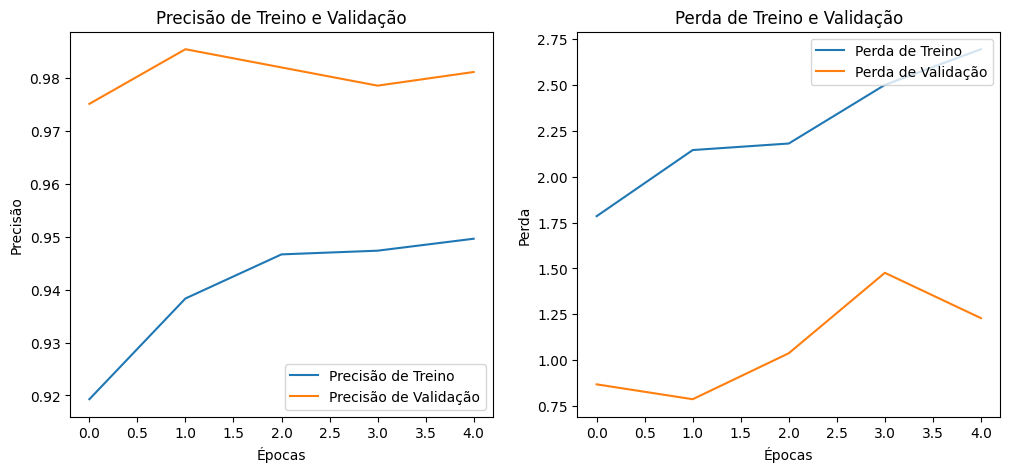

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Precisão de Treino')
plt.plot(epochs_range, val_acc, label='Precisão de Validação')
plt.legend(loc='lower right')
plt.title('Precisão de Treino e Validação')
plt.xlabel('Épocas')
plt.ylabel('Precisão')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Perda de Treino')
plt.plot(epochs_range, val_loss, label='Perda de Validação')
plt.legend(loc='upper right')
plt.title('Perda de Treino e Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')

plt.show()

## Análise dos Gráficos de Treinamento

Os gráficos de precisão mostram o comportamento do modelo. Abaixo tem-se uma referência de como ele deve ser comportar.

- **Sem Overfitting**: A Perda de Validação ( linha laranja, no gráfico à direita) não deve divergir da Perda de Treino. Ela se mantém baixa e estável, indicando que o modelo está generalizando bem para os dados que não viu durante o treino.

- **Desempenho da Validação Superior ao do Trein**o: É comum observar que a precisão de validação é maior (e a perda é menor) que a de treino. Isso não é um erro, mas sim um efeito esperado das nossas técnicas:

  1. **Dropout**: A camada de Dropout é ativa apenas durante o treino, tornando a tarefa artificialmente mais difícil para o modelo. Durante a validação, a camada é desativada e a rede completa é usada, resultando em um desempenho melhor.

  2. **Aumento de Dados**: As imagens de treino são constantemente modificadas (rotacionadas, com zoom, etc.), o que também dificulta o aprendizado. As imagens de validação são as originais e "limpas", tornando a tarefa de predição mais fácil.

- **Efeito do Early Stopping**: O gráfico pode não mostrar todas as 30 épocas. Se o treino parou antes (por exemplo, em 5 ou 8 épocas), é porque o EarlyStopping funcionou perfeitamente, concluindo o processo quando o modelo atingiu seu ponto ótimo de desempenho.



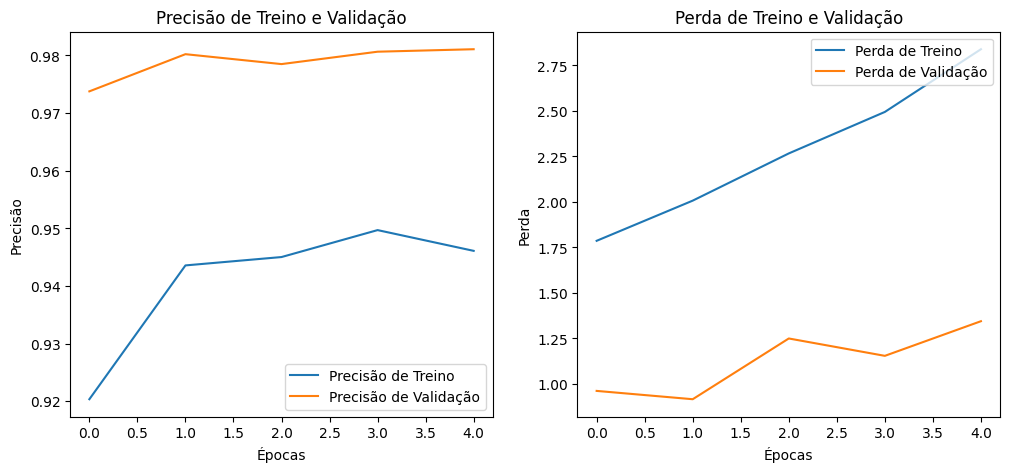